In [ ]:
import pandas as pd
import pickle
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import branca

In [ ]:
file = open('./pickles/house_latlong.p','rb')
house_df = pickle.load(file)


In [ ]:
#dropping NA values with lat long. 
house_df = house_df[~np.isnan(house_df.latitude)]
#redo this with the cosine(42) multiplication. 
house_df.loc[:,'e_long'] = house_df['longitude']*np.cos(np.radians(42))

In [ ]:
real_estate_df.Heating.value_counts()

#### Data Cleaning Notes:
Dropping following columns since they are Null/0 in more than 10% of the rows:  
- Alley
- PoolQC
- MiscFeature
- MiscVal (connected with MiscFeature)
- LowQualSF
- LandContour
- Electrical

Dropping because they aren't in the real_estate_df data:  
- Street
- Utilities
- RoofStyle
- Functional
- KitchenAbvGr
  'PavedDrive',
  'WoodDeckSF',
  'OpenPorchSF',
  'EnclosedPorch',
  '3SsnPorch',
  'ScreenPorch',
  'Fence',
  'BsmtFinType1',
  'BsmtFinType2',
  'HeatingQC'
  'GarageFinish'
  'Condition1,
  WasRemodeled

Drop but potentially come back:   
- FireplaceQu
- MSZoning, MSSubClass
- MasVnrType, MasVnrArea
- LotFrontage

Drop since higly correlated:   
- Condition2 (same as condition1)
- Exterior2nd (same as Exterior1)
- ExterCond (similar to ExterQual)
- GarageCond (similear to GarageQual)

Drop ID/Address numbers:  
- MapRefNo
- PID
- Prop_Addr 

Drop due to linear dependence:   
- GrLivArea (sum of 1stflr, 2ndflr) NOTE SWITCHED
- TotalBsmtSF (sum of BsmtFinSF1, BsmtFinSF2, BsmtUnfSF) NOTE SWITCHED
 
Booleanize columns:   
- Fence 

Feature Combining:  
- Bathrooms: Sum of all bathrooms
- 

#### Feature Engineering Notes
Reengineer OverallQual/Cond columns (linear regression on other material/quality columns)

In [ ]:
def quarter(month):
    if month<4:
        return('Q1')
    if month<7:
        return('Q2')
    if month<10:
        return('Q3')
    if month<13:
        return('Q4')

In [ ]:
df.MoSold.value_counts()

In [ ]:
#columns to drop:
drop_columns = ['Alley','PoolQC','MiscFeature','MiscVal',
                'FireplaceQu','MSSubClass','MSZoning',
                'Condition2','PID','MapRefNo','Prop_Addr',
                'MasVnrType','MasVnrArea','BsmtFinSF1',
                'BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF',
                'LowQualFinSF','ExterCond','Neighborhood','LotFrontage',
                'LotConfig','LotShape','LandContour','Exterior2nd',
                'GarageCond','Electrical','SaleType','SaleCondition',
                'Street','Utilities','RoofStyle','Functional','KitchenAbvGr',
                'PavedDrive','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                '3SsnPorch','ScreenPorch','Fence', 'BsmtFinType1',
                'BsmtFinType2','BsmtExposure','HeatingQC','GarageFinish','Condition1']
#copied dataframe with dropped columns:
df = house_df.drop(drop_columns,axis = 1)

##feature relations:
#bathrooms
df['bathrooms'] = df['FullBath'] + df['BsmtFullBath'] + 0.5*(df['BsmtHalfBath'] + df['HalfBath'])
df = df.drop(['FullBath','BsmtFullBath','BsmtHalfBath','HalfBath','bathrooms'],axis = 1) #dropped bathroom because its not in real_estate_df

#Age
df['Age'] = df['YrSold'] - df['YearRemodAdd']
#df['WasRemodeled'] = (df.YearRemodAdd != df.YearBuilt).astype(np.int64)
df = df.drop(['YrSold','YearRemodAdd','YearBuilt'],axis = 1)
#Fence
#df.loc[:,'Fence'] = (~df.Fence.isna()).astype(np.int64)
#Basement
df = df.drop(['BsmtCond',], axis = 1)
df.loc[:,'BsmtQual'][df['BsmtQual'].isna()] = 'TA'
#Garage
df['HasGarage'] = df.GarageArea.apply(lambda x: 1 if x > 0 else 0).astype(np.int64)
df = df.drop([col for col in list(df.columns) if 'Garage' in col],axis = 1)
df['Quarter'] = df.MoSold.apply(lambda x: quarter(x))
df = df.drop('MoSold',axis = 1)
df2 = df.copy()
#Dummify
#df_dropped = pd.get_dummies(df,drop_first = True)
df = pd.get_dummies(df)
#Last nulls set to 0
df[np.isnan(df)] = 0 

#Log of the SalePrice
#df.loc[:,'SalePrice'] = np.log(df['SalePrice'])

In [481]:
KNR = KNeighborsRegressor()

x_train, x_test, y_train, y_test = train_test_split(df.drop('SalePrice', axis = 1),
                                                    df['SalePrice'], test_size = .2,
                                                    random_state = 42)
params = {'n_neighbors':range(10,100)}
gcv_knr = GridSearchCV(KNR,param_grid = params)

gcv_knr.fit(x_train[['latitude','e_long']],y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(10, 100)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [482]:
gcv_knr.score(x_train[['latitude','e_long']],y_train), gcv_knr.score(x_test[['latitude','e_long']],y_test)

(0.761270677624868, 0.6697964124020531)

In [ ]:
KNR = KNeighborsRegressor()



x_train_pf, x_test_pf, y_train_pf, y_test_pf = train_test_split(df.drop('SalePrice', axis = 1),
                                                    df['SalePrice']/(df['GrLivArea']),
                                                    test_size = .2,
                                                    random_state = 42)

params = {'n_neighbors':range(10,100)}
gcv_knr_price_foot = GridSearchCV(KNR,param_grid = params)

gcv_knr_price_foot.fit(x_train_pf[['latitude','e_long']],y_train_pf)

In [ ]:
gcv_knr_price_foot.score(x_train_pf[['latitude','e_long']],y_train_pf), gcv_knr_price_foot.score(x_test_pf[['latitude','e_long']],y_test_pf)

In [ ]:
sum(x_train.ExterQual_Gd)

In [483]:
lam = .1 #really think about this value
linear_model_columns = x_train.columns
x_train.loc[:,'residuals'] = y_train - lam*gcv_knr.predict(x_train[['latitude','e_long']])
x_test.loc[:,'residuals'] = y_test - lam*gcv_knr.predict(x_test[['latitude','e_long']])

x_train = x_train.drop(['latitude','longitude','e_long'],axis = 1)
x_test = x_test.drop(['latitude','longitude','e_long'], axis =1)

In [484]:
lm_ridge = Ridge()
lmr_gcv = GridSearchCV(lm_ridge,param_grid={'alpha':[1,5,10]})
final_model = make_pipeline(StandardScaler(),lmr_gcv)
final_model.fit(x_train.drop('residuals', axis =1), x_train['residuals'])

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gridsearchcv',
                 GridSearchCV(cv=None, error_score=nan,
                              estimator=Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001),
                              iid='deprecated', n_jobs=None,
                              param_grid={'alpha': [1, 5, 10]},
                              pre_dispatch='2*n_jobs', refit=True,
                              return_train_score=False, scoring=None,
                              verbose=0))],
         verbose=False)

In [485]:
final_model.score(x_train.drop('residuals', axis =1), x_train['residuals']), final_model.score(x_test.drop('residuals', axis =1), x_test['residuals'])

(0.8907494838670404, 0.8824649869012972)

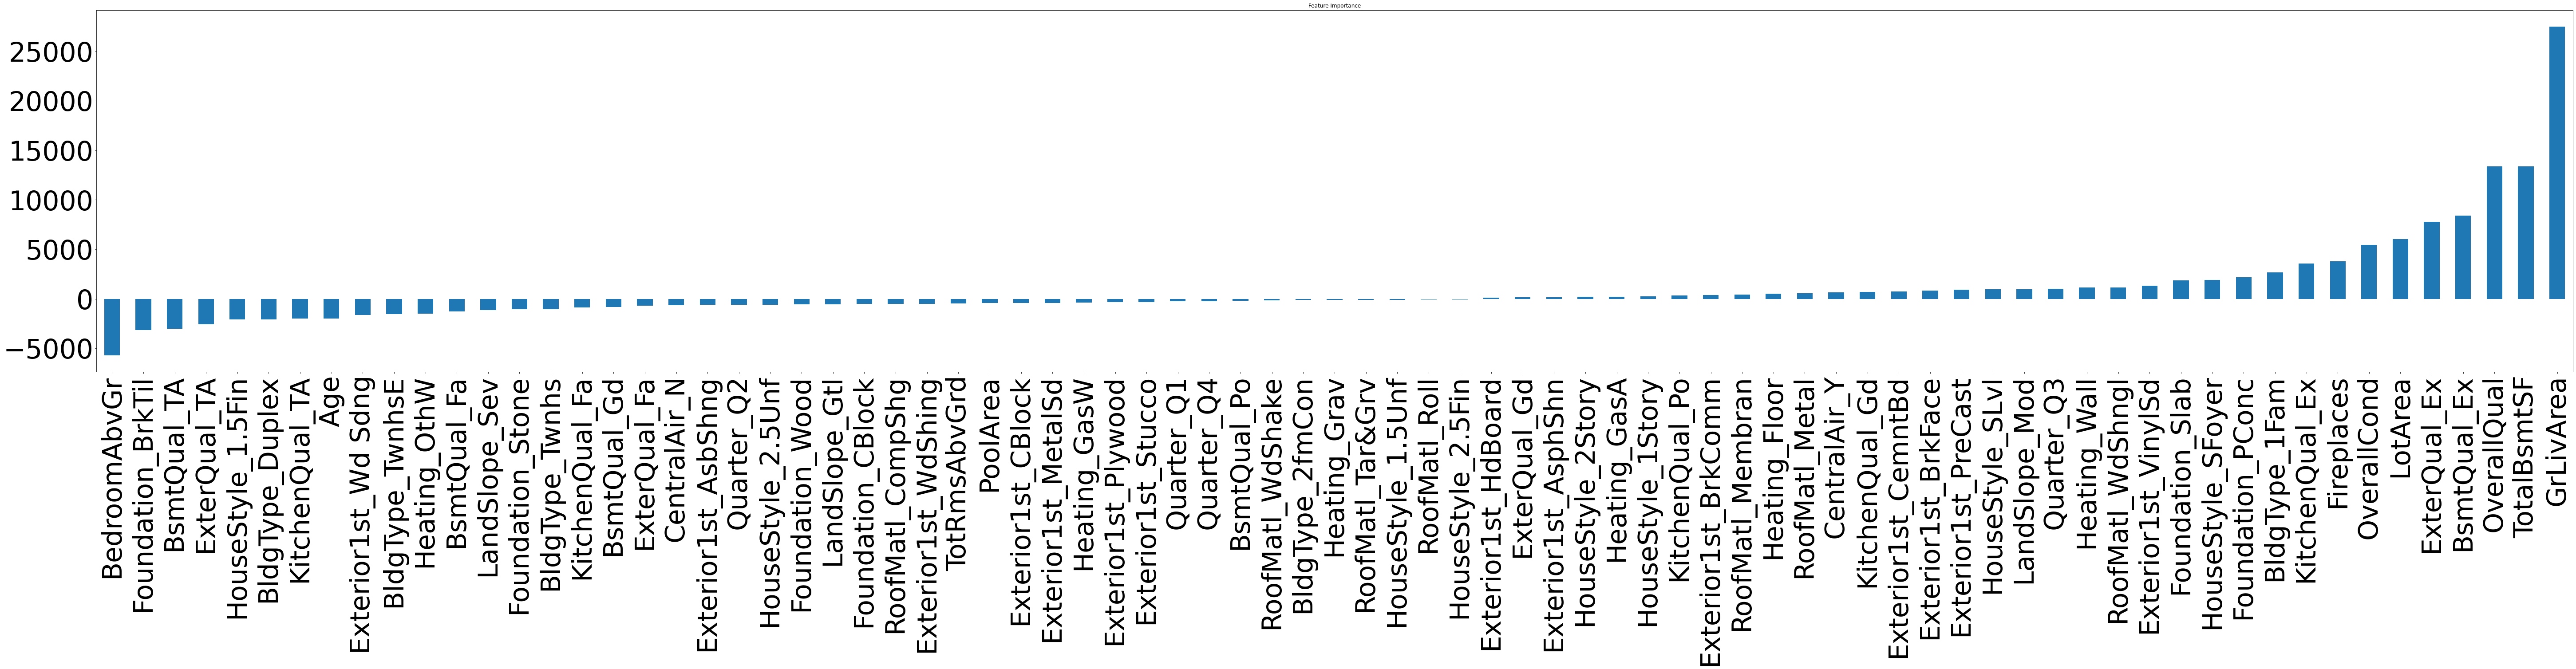

In [486]:
pd.Series(dict(zip(x_train.drop('residuals', axis =1).columns, final_model.named_steps.gridsearchcv.best_estimator_.coef_))).sort_values().plot.bar(rot = 90, figsize = (100,15),fontsize = 60, title = 'Feature Importance')

The reason exterqual_TA and exterqual_gd are so low is because they are below exterqual_ex which was dropped in the intercept! So they are less good. 

### How Do We Make Money

We want to use the real_estate dataset to identify houses to buy and estimate potential value per house. 



In [424]:
real_estate_df = pickle.load(open('./pickles/real_estate_latlong.p','rb'))
real_estate_df = real_estate_df[~real_estate_df['latitude'].isna()]
real_estate_df = real_estate_df[~real_estate_df['GLA'].isna()]
real_estate_df = real_estate_df[real_estate_df['SalePrice'].isna()]
real_estate_df = real_estate_df.rename(columns = {'GLA':'GrLivArea',
                                                  'YrSold_YYYY':'YrSold',
                                                  'MoSold_MM':'MoSold',
                                                  'Ext1':'Exterior1st',
                                                  'TtlBsmtSF':'TotalBsmtSF',
                                                  'YrBuilt':'YearBuilt',
                                                  'GarYrBlt':'GarageYrBlt',
                                                  'Cars':'GarageCars',
                                                  'Central Air':'CentralAir',
                                                  'NmbrBRs':'BedroomAbvGr'})
real_estate_df['YrSold'] = 2021 #Pretending to buy next year
real_estate_df['MoSold'] = 5 #Pretending to buy in Q2
real_estate_df.loc[:,'e_long'] = real_estate_df['longitude']*np.cos(np.radians(42))
real_estate_df['Age'] = real_estate_df['YrSold'] - real_estate_df['YearBuilt']
real_estate_df['Quarter'] = real_estate_df.MoSold.apply(lambda x: quarter(x))

Generate random data for the following columns:
'LandSlope',
'OverallQual',
'OverallCond',
'ExterQual',
'BsmtQual',
'KitchenQual'

In [ ]:
def clean_real_estate(col_name,df_1,df_2):
    '''
    Take out any rows from df_2.col_name which have values that don't appear in df_1
    '''
    values = df_1[col_name].unique()
    indices = []
    for i in df_2.index:
        x = df_2[col_name][i]
        if x not in values:
            indices.append(i)
    return(indices)

In [ ]:
#Randomly sample from the model dataframe to add data to the real_estate data
def random_impute(col_name):
    l = []
    for i in range(0,real_estate_df.shape[0]):
        l.append(df2[col_name].sample(1).iloc[0])
    return(l)

In [ ]:
def column_match(list1,list2):
    '''
    Inputs two columns of strings and outputs list of matching strings, 
    list of strings in list1 but not 2 and list of strings in list2 but not 1
    '''
    match_list = []
    diff_list = []
    
    for el in list1:
        if el in list2:
            match_list.append(el)
            list2.remove(el)
        else:
            diff_list.append(el)
    return(match_list,diff_list, list2)

In [ ]:
#Reassign heating columns
real_estate_df.Heating[real_estate_df.Heating == 'GasFWA'] = 'GasA'
real_estate_df.Heating[real_estate_df.Heating == 'GasHWat'] = 'GasW'
real_estate_df.Heating[real_estate_df.Heating == 'Gravity'] = 'Grav'
real_estate_df.Heating[real_estate_df.Heating == 'WallHtr'] = 'Wall'
real_estate_df.Heating[real_estate_df.Heating == 'OthrHW'] = 'OthW'
real_estate_df.Foundation[real_estate_df.Foundation == 'C\'Block'] = 'CBlock'
real_estate_df.Foundation[real_estate_df.Foundation == 'P\'Conc'] = 'PConc'
real_estate_df.Foundation[real_estate_df.Foundation == 'Brk/Til'] = 'BrkTil'
real_estate_df.HouseStyle = real_estate_df.HouseStyle.apply(lambda x: x.replace('-',''))
real_estate_df.HouseStyle = real_estate_df.HouseStyle.apply(lambda x: x.replace('/',''))
real_estate_df.HouseStyle = real_estate_df.HouseStyle.apply(lambda x: x.replace(' ',''))
real_estate_df.HouseStyle[real_estate_df.HouseStyle == 'SLevel'] = 'SLvl'
real_estate_df.BldgType[real_estate_df.BldgType == '1FamDet'] = '1Fam'
real_estate_df.BldgType[real_estate_df.BldgType == 'Twnhs-E'] = 'TwnhsE'
real_estate_df.BldgType[real_estate_df.BldgType == 'Twnhs-I'] = 'Twnhs'
real_estate_df.BldgType[real_estate_df.BldgType == '2FmConv'] = '2fmCon'
real_estate_df.CentralAir[real_estate_df.CentralAir == 'No'] = 'N'
real_estate_df.CentralAir[real_estate_df.CentralAir == 'Yes'] = 'Y'
real_estate_df.Exterior1st[real_estate_df.Exterior1st == 'C\'Block'] = 'CBlock'

In [426]:
columns_clean = ['RoofMatl','Heating','Foundation','Exterior1st','HouseStyle','BldgType','CentralAir']
for column_ in columns_clean:
    indices = clean_real_estate(column_,df2,real_estate_df)
    print(len(indices))
    real_estate_df = real_estate_df.drop(indices,axis = 0)

94
66
0
16
8
31
2


In [427]:
#randoml assign data for all of the condition and quality 
col1, col2, col3 = column_match(list(df2.columns),list(real_estate_df.columns))
for columns in col2:
    real_estate_df[columns] = random_impute(columns)

In [428]:
real_estate_df_model = real_estate_df[df2.columns]

In [429]:
#Dummify
real_estate_df_model = pd.get_dummies(real_estate_df_model)
real_estate_df_model['Quarter_Q1'] = 0
real_estate_df_model['Quarter_Q3'] = 0
real_estate_df_model['Quarter_Q4'] = 0
real_estate_df_model = real_estate_df_model[linear_model_columns]

In [431]:
real_estate_df_model['Location_Price'] = gcv_knr.predict(real_estate_df_model[['latitude','e_long']])
real_estate_df_model['Residuals'] = final_model.predict(real_estate_df_model.drop(['Location_Price','longitude','latitude','e_long'],axis = 1))

In [455]:
test_house = real_estate_df_model.drop(['Location_Price','longitude','latitude','e_long','Residuals'], axis = 1).loc[112,:].to_frame().transpose()

In [457]:
test_house_old = test_house.copy()
test_house.Quarter_Q2 = 0
test_house.Quarter_Q3 = 1
final_model.predict(test_house) - final_model.predict(test_house_old)

array([3480.12749854])

In [459]:
test_house.KitchenQual_TA = 0
test_house.KitchenQual_Ex = 1
final_model.predict(test_house) - final_model.predict(test_house_old)

array([23374.13238444])

In [487]:
test_house.OverallCond = 10
test_house.OverallQual = 10
test_house.ExterQual_TA = 0
test_house.ExterQual_Ex = 1
final_model.predict(test_house) - final_model.predict(test_house_old)

array([137901.63250863])

In [478]:
test_house.Age = 0
final_model.predict(test_house) - final_model.predict(test_house_old)

array([38833.47395698])

In [468]:
real_estate_df_model.loc[112,:]

GrLivArea           1456.000000
LotArea            11628.000000
OverallQual            6.000000
OverallCond            7.000000
TotalBsmtSF         1008.000000
                      ...      
Quarter_Q2             1.000000
Quarter_Q3             0.000000
Quarter_Q4             0.000000
Location_Price    166370.000000
Residuals         143743.385545
Name: 112, Length: 84, dtype: float64

In [488]:
real_estate_df_model.to_pickle('./pickles/realtor_clean.p')

In [489]:
pickle.dump(final_model,open('./pickles/final_model.p','wb'))

In [491]:
pickle.dump(gcv_knr,open('./pickles/location_model.p','wb'))